<a href="https://colab.research.google.com/github/julichitai/learning_NN/blob/MIPT/mipt%5Bseminar%5Dmetric_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5 Seminar

Hi! Today we are going to learn Metric Learning. We'll start with rank metrics, then move on to the Triple Loss objective and try to use another approach to get useful vector representations of objects.

https://drive.google.com/drive/folders/1FuLAB_72TtncRsAM3giErSJrtIWjOEzl

In [1]:
!pip install -U catalyst albumentations

     |████████████████████████████████| 491kB 9.1MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 317kB 17.7MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 
     |████████████████████████████████| 952kB 56.4MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
from catalyst.utils.misc import set_global_seed


set_global_seed(42)

# Metric Learning

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Metrics

Metric Learning objection is a finding such a vector presenations of objects that similar object should be near and different one far away. To understand model perfomance rank metrics are used. 

Let's generate some ranks sequences.

In [4]:
target_rank = np.arange(10)[:, np.newaxis].repeat(5, axis=1).T
predicted_rank = target_rank.copy()

for i in range(5):
    np.random.shuffle(target_rank[i])
for i in range(5):
    np.random.shuffle(predicted_rank[i])

In [5]:
print(f"Target rank of first class: {target_rank[0]}")
print(f"Predicted rank of first class: {predicted_rank[0]}")

Target rank of first class: [8 1 5 0 7 2 9 4 3 6]
Predicted rank of first class: [8 2 5 7 3 1 9 0 4 6]


### Recall

First at all, we have Recall. It's showed how much relative objects have been predicted in ratio of all objects in the data. It can use only first object or first five objects in prediction.

$$
\text{Recall}_k = \frac{\text{# predicted labels that are relevant}}{\text{# all labels}}
$$

In [6]:
recall_at_1 = (predicted_rank[:, 0] == target_rank[:, 0]) / target_rank.shape[1]
print(f"Recall@1: {recall_at_1}")

Recall@1: [0.1 0.1 0.  0.  0. ]


In [7]:
recall_at_5 = np.array([np.intersect1d(predicted_rank[c, :5], target_rank[c, :5]).shape[0] / target_rank.shape[1] for c in range(5)])
print(f"Recall@5: {recall_at_5}")

Recall@5: [0.3 0.3 0.2 0.2 0.2]


### mAP

Precision is usually used to present a model perfomance. 

$$
\text{Precision}_k = \frac{\text{# predicted labels that are relevant}}{\text{# all predicted labels}}
$$

However, for more accurate perfomnace estimation precison is weighted by recall:

$$
\text{AP}_K = \sum_{k = 1}^K (\text{Recall}_k - \text{Recall}_{k - 1}) \text{Precision}_k
$$

To undestand entire model perfomance $\text{AP}$ can be averaged across all classes. This metrics is called $\text{mAP}$.


In [8]:
recall_at = lambda k:  np.array([np.intersect1d(predicted_rank[c, :k], target_rank[c, :k]).shape[0] / target_rank.shape[1] for c in range(5)])
precision_at = lambda k:  np.array([np.intersect1d(predicted_rank[c, :k], target_rank[c, :k]).shape[0] / k for c in range(5)])

In [9]:
recall_at_10 = np.array([recall_at(k) for k in range(1, 11)])
print(recall_at_10[:, 0])

[0.1 0.1 0.2 0.2 0.3 0.5 0.6 0.7 0.9 1. ]


In [10]:
precision_at_10 = np.array([precision_at(k) for k in range(1, 11)])
print(precision_at_10[:,0])

[1.         0.5        0.66666667 0.5        0.6        0.83333333
 0.85714286 0.875      1.         1.        ]


In [11]:
AP_0_at_10 = np.sum(precision_at_10[1:, 0] * (recall_at_10[1:, 0] - recall_at_10[:-1, 0]))
print(AP_0_at_10)

0.7665476190476191


In [12]:
AP_at_10 = np.sum(precision_at_10[1:, :] * (recall_at_10[1:, :] - recall_at_10[:-1, :]), axis=0)
print(AP_at_10)

[0.76654762 0.70563492 0.72563492 0.72253968 0.73007937]


In [13]:
mAP_at_10 = np.mean(AP_at_10)
print(mAP_at_10)

0.7300873015873016


### Cumulative Matching Characteristic
Cumulative Matching Characteristics (CMC) curves are the most popular evaluation metrics for person re-identification methods. Consider a simple single-gallery-shot setting, where each gallery identity has only one instance. For each query the top-k accuracy is

$$
\text{Acc}_k = \cases{1, \text{ if top-k ranked gallery samples contain the query identity} \\ 0,\text{ otherwise}}
$$


And $\text{CMC}$ is the average $\text{Acc}_k$ across queries.

In [14]:
acc_k = lambda k: np.array([np.isin(c, target_rank[c, :k]) * 1 for c in range(5)])
print(acc_k(6))

[1 1 1 0 1]


In [15]:
cmc = np.mean(acc_k(6))
print(cmc)

0.8


## Omniglot

Introduce new dataset: [Omniglot](https://github.com/brendenlake/omniglot). It contains 1623 different handwritten characters from 50 different alphabets. They have been written by 20 different people and collect via Amazon's Mechanical Turk. Some of the characters are presented on the picture:

![photo](https://raw.githubusercontent.com/brendenlake/omniglot/master/omniglot_grid.jpg)

In [16]:
# Download dataset
!git clone https://github.com/brendenlake/omniglot
!unzip omniglot/python/images_background
!unzip omniglot/python/images_evaluation

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images_evaluation/Mongolian/character28/1386_05.png  
  inflating: images_evaluation/Mongolian/character28/1386_06.png  
  inflating: images_evaluation/Mongolian/character28/1386_07.png  
  inflating: images_evaluation/Mongolian/character28/1386_08.png  
  inflating: images_evaluation/Mongolian/character28/1386_09.png  
  inflating: images_evaluation/Mongolian/character28/1386_10.png  
  inflating: images_evaluation/Mongolian/character28/1386_11.png  
  inflating: images_evaluation/Mongolian/character28/1386_12.png  
  inflating: images_evaluation/Mongolian/character28/1386_13.png  
  inflating: images_evaluation/Mongolian/character28/1386_14.png  
  inflating: images_evaluation/Mongolian/character28/1386_15.png  
  inflating: images_evaluation/Mongolian/character28/1386_16.png  
  inflating: images_evaluation/Mongolian/character28/1386_17.png  
  inflating: images_evaluation/Mongolian/character28/1386_18.

Look at the file structure. Each folder is called after alphabetic system and contains character's folder with drawn examples.

Let's show the `a` character from the Latin alphabet.

In [19]:
!ls images_background/

 Alphabet_of_the_Magi
 Anglo-Saxon_Futhorc
 Arcadian
 Armenian
'Asomtavruli_(Georgian)'
 Balinese
 Bengali
'Blackfoot_(Canadian_Aboriginal_Syllabics)'
 Braille
'Burmese_(Myanmar)'
 Cyrillic
 Early_Aramaic
 Futurama
 Grantha
 Greek
 Gujarati
 Hebrew
'Inuktitut_(Canadian_Aboriginal_Syllabics)'
'Japanese_(hiragana)'
'Japanese_(katakana)'
 Korean
 Latin
'Malay_(Jawi_-_Arabic)'
'Mkhedruli_(Georgian)'
 N_Ko
'Ojibwe_(Canadian_Aboriginal_Syllabics)'
 Sanskrit
'Syriac_(Estrangelo)'
 Tagalog
 Tifinagh


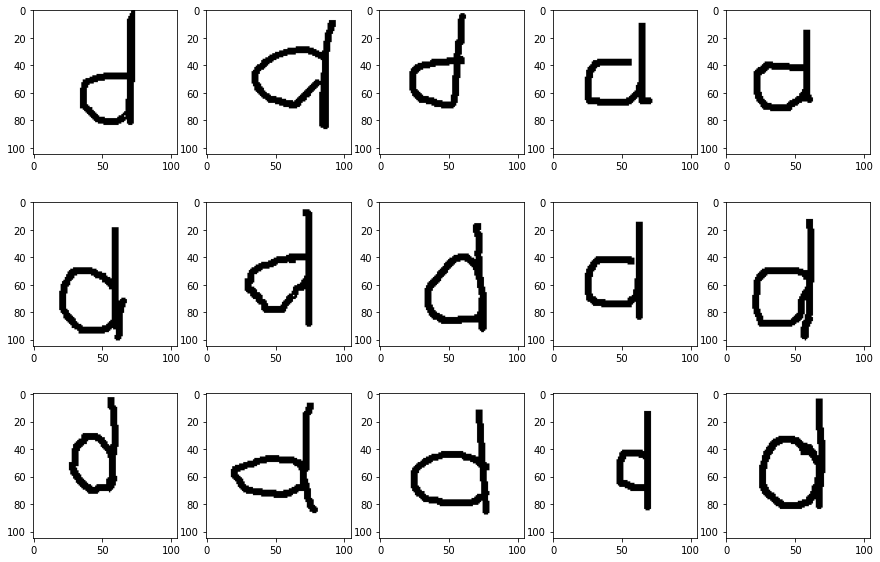

In [21]:
from pathlib import Path


latin_a = Path("images_background") / "Latin" / "character04"
paths = list(latin_a.glob("*.png"))

_, axs = plt.subplots(3, 5, figsize=(15, 10))

for i in range(15):
    image = Image.open(paths[i])
    axs[i % 3][i % 5].imshow(image)

We use `images_background` as train part of dataset and `images_evaluation` as valid part.

In [18]:
data = {
    "train": {"labels": [], "image_paths": [], "cls2label": {}, "root": Path("images_background")},
    "valid": {"labels": [], "image_paths": [], "cls2label": {}, "root": Path("images_evaluation")}
}

for part in data:
    cur_part = data[part]
    for alphabet_path in cur_part["root"].iterdir():
        for ch in alphabet_path.iterdir():
            cur_part["labels"].extend(f"{alphabet_path.name}_{ch.name}" for _ in ch.glob("*.png"))
            cur_part["image_paths"].extend(ch.glob("*.png"))
    
    cur_part["labels"] = np.array(cur_part["labels"])
    cur_part["image_paths"] = np.array(cur_part["image_paths"])
    cur_part["cls2label"] = {c: num for num, c in enumerate(np.unique(cur_part["labels"]))}

In [26]:
data['valid']

{'cls2label': {'Angelic_character01': 0,
  'Angelic_character02': 1,
  'Angelic_character03': 2,
  'Angelic_character04': 3,
  'Angelic_character05': 4,
  'Angelic_character06': 5,
  'Angelic_character07': 6,
  'Angelic_character08': 7,
  'Angelic_character09': 8,
  'Angelic_character10': 9,
  'Angelic_character11': 10,
  'Angelic_character12': 11,
  'Angelic_character13': 12,
  'Angelic_character14': 13,
  'Angelic_character15': 14,
  'Angelic_character16': 15,
  'Angelic_character17': 16,
  'Angelic_character18': 17,
  'Angelic_character19': 18,
  'Angelic_character20': 19,
  'Atemayar_Qelisayer_character01': 20,
  'Atemayar_Qelisayer_character02': 21,
  'Atemayar_Qelisayer_character03': 22,
  'Atemayar_Qelisayer_character04': 23,
  'Atemayar_Qelisayer_character05': 24,
  'Atemayar_Qelisayer_character06': 25,
  'Atemayar_Qelisayer_character07': 26,
  'Atemayar_Qelisayer_character08': 27,
  'Atemayar_Qelisayer_character09': 28,
  'Atemayar_Qelisayer_character10': 29,
  'Atemayar_Qelis

## Metric Learning Pipeline

Look at the Metric Learning pipeline in training stage

![training stage](https://miro.medium.com/max/1400/1*_kwjkuV7MtJCCYriwwo3uA.png)

and in validation stage 

![validating stage](https://miro.medium.com/max/1400/1*w3NVYqXA_e-EwWrvnvvrDw.png)


(from [Metric Learning with Catalyst](https://medium.com/pytorch/metric-learning-with-catalyst-8c8337dfab1a) by [@AlexeySh](https://github.com/AlekseySh))

To train model for Netric Learning objective, we need:

- Metric Learning Dataset for training
- Query/Gallery Dataset for validation
- In-batch sampler of triplets
- Triplet Loss criterion

Implement each part step by step.



### Data Loaders

Metric Learning Dataset is similar with usual dataset. One difference is the `get_labels` method. It should return all labels in dataset. That used for class balanced batch sampler.

In [27]:
import torch
from catalyst.contrib.utils.cv.image import imread
from catalyst.data.dataset.metric_learning import (
    MetricLearningTrainDataset,
    QueryGalleryDataset,
)
from torch.utils.data import Dataset


class OmniGlotMLDataset(MetricLearningTrainDataset):
    def __init__(
        self,
        images,
        targets,
        transform=None
    ):
        self.images = images
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        img, target = self.images[index], int(self.targets[index])
        img = imread(img)

        if self.transform is not None:
            img = self.transform(image=img)["image"]
        
        return img, target

    def get_labels(self):
        return self.targets.tolist()

    def __len__(self):
        return self.images.shape[0]

For validation, we need to create an Query-Gallery Dataset. Some of the object must be marked as query.

In [29]:
class OmniGlotQGDataset(QueryGalleryDataset):

    def __init__(
        self,
        images,
        targets,
        transform=None,
        gallery_fraq=0.2,
    ):
        self._omniglot = OmniGlotMLDataset(
            images=images, targets=targets, transform=transform
        )

        self._gallery_size = int(gallery_fraq * len(self._omniglot))
        self._query_size = len(self._omniglot) - self._gallery_size

        self._is_query = torch.zeros(len(self._omniglot)).type(torch.bool)
        self._is_query[: self._query_size] = True

    def __getitem__(self, idx: int):
        image, label = self._omniglot[idx]
        return {
            "features": image,
            "targets": label,
            "is_query": self._is_query[idx],
        }

    def __len__(self):
        return len(self._omniglot)

    @property
    def gallery_size(self):
        return self._gallery_size

    @property
    def query_size(self):
        return self._query_size

We need `BalanceBatchSampler`. This sampler behaviour guarantees that we can always form the triplets inside the batch and overcome classes’ imbalance

These code is copied from the `Catalyst` codebase.

In [30]:
from torch.utils.data import DataLoader, Sampler


class BalanceBatchSampler(Sampler):
    """
    This kind of sampler can be used for both metric learning and
    classification task.
    Sampler with the given strategy for the C unique classes dataset:
    - Selection P of C classes for the 1st batch
    - Selection K instances for each class for the 1st batch
    - Selection P of C - P remaining classes for 2nd batch
    - Selection K instances for each class for the 2nd batch
    - ...
    The epoch ends when there are no classes left.
    So, the batch sise is P * K except the last one.
    Thus, in each epoch, all the classes will be selected once, but this
    does not mean that all the instances will be selected during the epoch.
    One of the purposes of this sampler is to be used for
    forming triplets and pos/neg pairs inside the batch.
    To guarante existance of these pairs in the batch,
    P and K should be > 1. (1)
    Behavior in corner cases:
    - If a class does not contain K instances,
    a choice will be made with repetition.
    - If C % P == 1 then one of the classes should be dropped
    otherwise statement (1) will not be met.
    This type of sampling can be found in the classical paper of Person Re-Id,
    where P equals 32 and K equals 4:
    `In Defense of the Triplet Loss for Person Re-Identification`_.
    .. _In Defense of the Triplet Loss for Person Re-Identification:
        https://arxiv.org/abs/1703.07737
    """

    def __init__(self, labels, p, k):
        """
        Args:
            labels: list of classes labeles for each elem in the dataset
            p: number of classes in a batch, should be > 1
            k: number of instances of each class in a batch, should be > 1
        """
        super().__init__(self)
        classes = set(labels)

        self._labels = labels
        self._p = p
        self._k = k

        self._batch_size = self._p * self._k
        self._classes = classes

        # to satisfy statement (1)
        num_classes = len(self._classes)
        if num_classes % self._p == 1:
            self._num_epoch_classes = num_classes - 1
        else:
            self._num_epoch_classes = num_classes

    @property
    def batch_size(self):
        """
        Returns:
            this value should be used in DataLoader as batch size
        """
        return self._batch_size

    @property
    def batches_in_epoch(self):
        """
        Returns:
            number of batches in an epoch
        """
        return int(np.ceil(self._num_epoch_classes / self._p))

    def __len__(self):
        """
        Returns:
            number of samples in an epoch
        """
        return self._num_epoch_classes * self._k

    def __iter__(self):
        """
        Returns:
            indeces for sampling dataset elems during an epoch
        """
        inds = []

        for cls_id in sample(self._classes, self._num_epoch_classes):
            all_cls_inds = find_value_ids(self._labels, cls_id)

            # we've checked in __init__ that this value must be > 1
            num_samples_exists = len(all_cls_inds)

            if num_samples_exists < self._k:
                selected_inds = sample(
                    all_cls_inds, k=num_samples_exists
                ) + choices(all_cls_inds, k=self._k - num_samples_exists)
            else:
                selected_inds = sample(all_cls_inds, k=self._k)

            inds.extend(selected_inds)

        return iter(inds)

We won't use augmentation in our pipeline. But the reason we'll use `albumentations` is that it has convinient tools for the image preprocessing. 

In [31]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor


IMAGE_SIZE = 64

transform = albu.Compose([
    albu.LongestMaxSize(IMAGE_SIZE),
    albu.PadIfNeeded(IMAGE_SIZE, IMAGE_SIZE, border_mode=0),
    albu.Normalize(),
    ToTensor()
])

Process train/valid data, create datasets and loaders.

In [64]:
train_images = data["train"]["image_paths"]
train_labels = data["train"]["labels"]

indexes = np.arange(train_images.shape[0])
np.random.shuffle(indexes)
train_images = train_images[indexes]
train_targets = np.array([data["train"]["cls2label"][c] for c in train_labels])[indexes]

dataset_train = OmniGlotMLDataset(images=train_images, targets=train_targets, transform=transform)
sampler = BalanceBatchSampler(labels=dataset_train.get_labels(), p=8, k=16)
train_loader = DataLoader(dataset=dataset_train, sampler=sampler, batch_size=sampler.batch_size)

In [33]:
valid_images = data["valid"]["image_paths"]
valid_labels = data["valid"]["labels"]
valid_targets = np.array([data["valid"]["cls2label"][c] for c in valid_labels])

dataset_valid = OmniGlotQGDataset(images=valid_images, targets=valid_targets, transform=transform, gallery_fraq=0.2)
valid_loader = DataLoader(dataset=dataset_valid, batch_size=256)

### Training


We need the triplet generator for metric learning pipeline. The most popular one is `AllTriplets` and `HardTrpilet`. They are implemented in the catalyst. However, let's look their through code deeply.

In [34]:
from itertools import combinations, product
from random import sample
from sys import maxsize

from catalyst.data import InBatchTripletsSampler
from catalyst.utils.misc import find_value_ids
from catalyst.utils.torch import normalize, convert_labels2list


class AllTripletsSampler(InBatchTripletsSampler):
    """
    This sampler selects all the possible triplets for the given labels
    """

    def __init__(self, max_output_triplets=maxsize):
        """
        Args:
            max_output_triplets: with the strategy of choosing all
                the triplets, their number in the batch can be very large,
                because of it we can sample only random part of them,
                determined by this parameter.
        """
        self._max_out_triplets = max_output_triplets

    def _sample(self, *_, labels):
        """
        Args:
            labels: labels of the samples in the batch
            *_: note, that we ignore features argument
        Returns: indeces of triplets
        """
        num_labels = len(labels)

        triplets = []
        for label in set(labels):
            ids_pos_cur = set(find_value_ids(labels, label))
            ids_neg_cur = set(range(num_labels)) - ids_pos_cur

            pos_pairs = list(combinations(ids_pos_cur, r=2))

            tri = [(a, p, n) for (a, p), n in product(pos_pairs, ids_neg_cur)]
            triplets.extend(tri)

        triplets = sample(triplets, min(len(triplets), self._max_out_triplets))
        ids_anchor, ids_pos, ids_neg = zip(*triplets)

        return list(ids_anchor), list(ids_pos), list(ids_neg)

In [39]:
test_sampler = AllTripletsSampler(max_output_triplets=10)
test_sampler._sample(labels = [0, 0, 1, 1, 2, 2, 2])

([5, 4, 0, 0, 0, 2, 2, 2, 2, 5],
 [6, 5, 1, 1, 1, 3, 3, 3, 3, 6],
 [0, 3, 3, 2, 4, 1, 4, 5, 6, 3])

Torch has the TripletLoss criterion. But it doesn't work with in-batch sampler. We must join these two enteties in new one. It has to sample triplets by the given rule and calculate triplet loss with the margin.

In [40]:
import torch.nn as nn


class TripletMarginLossWithSampler(nn.Module):
    """
    This class combines in-batch sampling of triplets and
    default TripletMargingLoss from PyTorch.
    """

    def __init__(self, margin, sampler_inbatch):
        """
        Args:
            margin: margin value
            sampler_inbatch: sampler for forming triplets inside the batch
        """
        super().__init__()
        self._sampler_inbatch = sampler_inbatch
        self._triplet_margin_loss = TripletMarginLoss(margin=margin)

    def forward(self, features, labels):
        """
        Args:
            features: features with the shape of [batch_size, features_dim]
            labels: labels of samples having batch_size elements
        Returns: loss value
        """
        labels_list = convert_labels2list(labels)

        (
            features_anchor,
            features_positive,
            features_negative,
        ) = self._sampler_inbatch.sample(features=features, labels=labels_list)

        loss = self._triplet_margin_loss(
            anchor=features_anchor,
            positive=features_positive,
            negative=features_negative,
        )
        return loss

Create simple model with pretrained MobileNet backbone. It's able to increase training time. Good model must be trained for long time (several hundreads epochs). For educational purposes, we adjust train time to one epoch.

In [44]:
from catalyst import dl, utils
from catalyst.contrib import models
from catalyst.contrib.nn import TripletMarginLossWithSampler, RAdam

from torchvision.models import mobilenet_v2


base_model = mobilenet_v2(pretrained=True)
model = nn.Sequential(
        base_model.features,
        nn.AdaptiveMaxPool2d((1, 1)),
        nn.Flatten()
)
optimizer = RAdam(model.parameters(), lr=0.01)

# 3. criterion with triplets sampling
sampler_inbatch = AllTripletsSampler()
criterion = TripletMarginLossWithSampler(margin=0.3, sampler_inbatch=sampler_inbatch)

# 4. training with catalyst Runner
callbacks = [
    dl.ControlFlowCallback(dl.CriterionCallback(), loaders="train"),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[5]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=1),
]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [45]:
runner = dl.SupervisedRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=1,
    main_metric="cmc05",
)

1/1 * Epoch (train):   1% 1/121 [00:01<03:19,  1.66s/it, loss=2.238]

/usr/local/lib/python3.6/dist-packages/catalyst/contrib/nn/optimizers/radam.py:85: UserWarning:

This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)



1/1 * Epoch (train): 100% 121/121 [00:54<00:00,  2.23it/s, loss=0.012]
1/1 * Epoch (valid): 100% 52/52 [00:15<00:00,  3.40it/s]
[2021-01-22 06:41:23,473] 
1/1 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/1 * Epoch 1 (train): loss=0.2124
1/1 * Epoch 1 (valid): cmc05=0.0003


Let's implement `HardTriplet` sampler and compare it with the `AllTriplet` one.

In [46]:
class HardTripletsSampler(InBatchTripletsSampler):
    """
    This sampler selects hardest triplets based on distances between features:
    the hardest positive sample has the maximal distance to the anchor sample,
    the hardest negative sample has the minimal distance to the anchor sample.
    Note that a typical triplet loss chart is as follows:
    1. Falling: loss decreases to a value equal to the margin.
    2. Long plato: the loss oscillates near the margin.
    3. Falling: loss decreases to zero.
    """

    def __init__(self, norm_required=False):
        """
        Args:
            norm_required: set True if features normalisation is needed
        """
        self._norm_required = norm_required

    def _sample(self, features, labels):
        """
        This method samples the hardest triplets inside the batch.
        Args:
            features: has the shape of [batch_size, feature_size]
            labels: labels of the samples in the batch
        Returns:
            the batch of the triplets in the order below:
            (anchor, positive, negative)
        """
        assert features.shape[0] == len(labels)

        if self._norm_required:
            features = normalize(samples=features.detach())

        dist_mat = torch.cdist(x1=features, x2=features, p=2)

        ids_anchor, ids_pos, ids_neg = self._sample_from_distmat(
            distmat=dist_mat, labels=labels
        )

        return ids_anchor, ids_pos, ids_neg

    @staticmethod
    def _sample_from_distmat(distmat, labels):
        """
        This method samples the hardest triplets based on the given
        distances matrix. It chooses each sample in the batch as an
        anchor and then finds the harderst positive and negative pair.
        Args:
            distmat: matrix of distances between the features
            labels: labels of the samples in the batch
        Returns:
            the batch of triplets in the order below:
            (anchor, positive, negative)
        """
        ids_all = set(range(len(labels)))

        ids_anchor, ids_pos, ids_neg = [], [], []

        for i_anch, label in enumerate(labels):
            ids_label = set(find_value_ids(it=labels, value=label))

            ids_pos_cur = np.array(list(ids_label - {i_anch}), int)
            ids_neg_cur = np.array(list(ids_all - ids_label), int)

            i_pos = ids_pos_cur[distmat[i_anch, ids_pos_cur].argmax()]
            i_neg = ids_neg_cur[distmat[i_anch, ids_neg_cur].argmin()]

            ids_anchor.append(i_anch)
            ids_pos.append(i_pos)
            ids_neg.append(i_neg)

        return ids_anchor, ids_pos, ids_neg

Check that all parameters are the same.

In [48]:
base_model = mobilenet_v2(pretrained=True)
model = nn.Sequential(
        base_model.features,
        nn.AdaptiveMaxPool2d((1, 1)),
        nn.Flatten()
)
optimizer = RAdam(model.parameters(), lr=0.01)

# 3. criterion with triplets sampling
sampler_inbatch = HardTripletsSampler()
criterion = TripletMarginLossWithSampler(margin=0.3, sampler_inbatch=sampler_inbatch)

# 4. training with catalyst Runner
callbacks = [
    dl.ControlFlowCallback(dl.CriterionCallback(), loaders="train"),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[5]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=1),
]

In [49]:
runner = dl.SupervisedRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=1,
    main_metric="cmc05",
)

1/1 * Epoch (train): 100% 121/121 [00:20<00:00,  6.02it/s, loss=5.428]
1/1 * Epoch (valid): 100% 52/52 [00:14<00:00,  3.55it/s]
[2021-01-22 07:12:32,037] 
1/1 * Epoch 1 (_base): lr=0.0100 | momentum=0.9000
1/1 * Epoch 1 (train): loss=7.0408
1/1 * Epoch 1 (valid): cmc05=0.000e+00


## *Face for Class Identification

![](https://asset-pdf.scinapse.io/prod/2786817236/figures/figure-2.jpg)

Another way to train vector presentation is using *Face methods: SphereFace, CosFace and ArcFace. It used simple `CrossEntropyLoss` with additional techniques to separate classes in a hyperbolic sphere. We'll implement `CosFace`. It's easy to understand and to write.

In [51]:
import math

import torch.nn.functional as F


class CosFace(nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        s: float = 10,
        m: float = 0.25,
    ):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(
            torch.FloatTensor(out_features, in_features)
        )
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, target):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size()).to(input.device)
        one_hot.scatter_(1, target.view(-1, 1).long(), 1)
        logits = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logits *= self.s

        return logits

In [61]:
input = torch.rand(10, 10)
cf = CosFace(10, 10)
cf(input, target=torch.arange(10).reshape(-1, 1))

tensor([[-4.1215, -2.7659,  2.9493,  0.4211,  1.2484, -6.1933,  0.7414, -8.5011,
          2.4884, -3.6635],
        [-3.4493, -5.3257, -0.5431,  1.2502,  3.7021, -7.9641,  1.8730, -5.7763,
         -0.7627, -5.5577],
        [-0.9560, -2.2289, -1.4298, -0.1996,  2.6078, -7.7153,  0.5959, -7.3892,
         -0.0482, -6.2877],
        [ 0.6646, -2.5107, -0.5778, -2.1938,  3.9399, -6.4801,  4.1301, -8.0216,
          2.6199, -5.6711],
        [-0.1257, -1.8742,  2.0239,  0.5109, -0.3623, -6.3993,  1.6374, -9.0987,
          3.0927, -5.9019],
        [-1.8453, -4.0517,  1.7465,  2.8908,  1.7882, -9.3656,  1.7184, -6.7557,
          2.8747, -6.1381],
        [-1.2976, -2.7162,  0.0873, -1.1836,  3.0878, -5.2707, -2.8749, -6.5774,
         -0.5959, -6.5528],
        [-1.4326, -4.0350,  0.4201,  1.1249,  2.1065, -8.0339,  3.0450, -8.8749,
          1.1183, -4.5026],
        [-1.2900, -2.2714,  1.9635, -0.4239,  1.5171, -5.6575,  1.8376, -8.8749,
         -0.3297, -4.9422],
        [ 3.1799, -

Notice that we don't need special sampler for this pipeline. It can be added as class balancer, but the pipeline can be simplified.

In [65]:
dataset_train = OmniGlotMLDataset(images=train_images, targets=train_targets, transform=transform)
train_loader = DataLoader(dataset=dataset_train, batch_size=sampler.batch_size)

dataset_valid = OmniGlotQGDataset(images=valid_images, targets=valid_targets, transform=transform, gallery_fraq=0.2)
valid_loader = DataLoader(dataset=dataset_valid, batch_size=256)

We need the special model class and runner. A model should process features and targets in training procedure. And in validation period the model returns only extracted feature vector.

In [66]:
class OmniGlotModel(nn.Module):
    def __init__(self, num_training_classes):
        super().__init__()

        base_model = mobilenet_v2(pretrained=True)
        self.feature_extractor = nn.Sequential(
                base_model.features,
                nn.AdaptiveMaxPool2d((1, 1)),
                nn.Flatten(),
        )

        self.face = CosFace(1280, num_training_classes)

    def forward(self, features, targets=None):
        features = self.feature_extractor(features)
        if self.training and (targets is not None):
            output = self.face(features, targets)
        else:
            output = F.normalize(features)
        return output

In [67]:
class FaceRunner(dl.SupervisedRunner):
    def predict_batch(self, batch):
        return {"features": self.model(batch["features"].to(self.device)), "targets": batch["targets"]}

    def _handle_batch(self, batch):
        if self.model.training:
            y_pred = self.model(batch["features"], batch["targets"])
        else:
            y_pred = self.model(batch["features"])
        self.output = {"logits": y_pred}

Let's train and compare results with TripletLoss.

In [68]:
model = OmniGlotModel(np.unique(train_labels).shape[0])
optimizer = RAdam(model.parameters(), lr=0.1)

criterion = nn.CrossEntropyLoss()

callbacks = [
    dl.ControlFlowCallback(dl.CriterionCallback(), loaders="train"),
    dl.ControlFlowCallback(dl.CMCScoreCallback(topk_args=[5]), loaders="valid"),
    dl.PeriodicLoaderCallback(valid=1),
]

In [69]:
runner = FaceRunner(device=utils.get_device())
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    callbacks=callbacks,
    loaders={"train": train_loader, "valid": valid_loader},
    minimize_metric=False,
    verbose=True,
    valid_loader="valid",
    num_epochs=1,
    main_metric="cmc05",
)

1/1 * Epoch (train): 100% 151/151 [00:19<00:00,  7.66it/s, loss=6.251]
1/1 * Epoch (valid): 100% 52/52 [00:14<00:00,  3.53it/s]
[2021-01-22 07:28:07,445] 
1/1 * Epoch 1 (_base): lr=0.1000 | momentum=0.9000
1/1 * Epoch 1 (train): loss=7.4295
1/1 * Epoch 1 (valid): cmc05=0.0002


## Visualization

Look at the final results! You need to project feature vectors to 2D space and plot them.

In [57]:
# !pip install umap-learn

In [70]:
import seaborn as sns

from umap import UMAP

In [71]:
results = {"features": [], "targets": []}
for prediction in runner.predict_loader(loader=valid_loader):
    results["features"].extend(feature for feature in prediction["features"].cpu().numpy())
    results["targets"].extend(feature for feature in prediction["targets"].cpu().numpy())

In [72]:
proj = UMAP(n_components=2)
new_features = proj.fit_transform(np.array(results["features"])[np.isin(results["targets"],np.arange(10))])

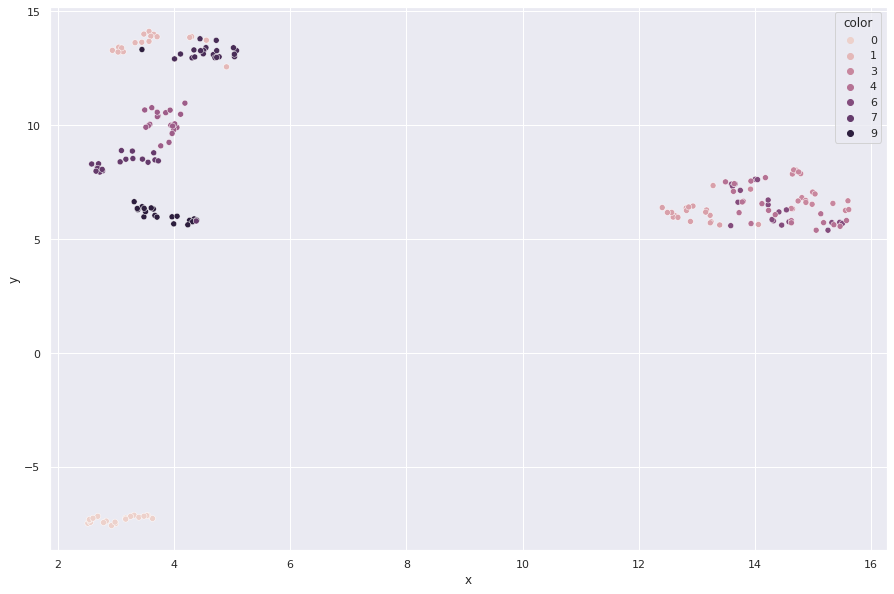

In [73]:
plot = {"x": new_features[:, 0], "y": new_features[:, 1], "color": np.array(results["targets"])[np.isin(results["targets"],np.arange(10))]}

sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x="x", y="y", hue="color", data=plot, ax=ax)